In [1]:
import os
import pandas as pd
from Util.Preprocess import PreProcessor
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.layers import Input, Dense
from keras.layers.recurrent import LSTM
from keras.models import Model

'''Creates LSTM and evaluates it on how well it predicts daily closing price
   Assumes there is a file with OHLCV data in current working directory
   If dataset does not exists refer to gdaxScraper.py'''

'''Specify filepath, should be in the directory of lstm.py'''


Using TensorFlow backend.


In [43]:
import csv
import sqlite3

conn=sqlite3.connect("binance_data/binance_0.1.db")
c=conn.cursor()

tableC = c.execute("select name from sqlite_master where type = 'table'")
tables = []
for t in tableC:
    if "candles" in t[0]:
        tables.append(t[0])
    
tables[1:10]

['candles_USDT_BTC',
 'candles_BNB_ADA',
 'candles_BTC_AGI',
 'candles_BTC_AE',
 'candles_BTC_AION',
 'candles_BTC_ADA',
 'candles_BTC_ARDR',
 'candles_BTC_ARK',
 'candles_BTC_AMB']

In [44]:
len(tables)

152

In [ ]:
'''

table_name = "candles_USDT_BTC"
cmd = "select * from " + str(table_name)
dataC = c.execute(cmd)

col_names= ['time', 'open', 'high', 'low', 'close']
col_num = len(col_names)

df = pd.DataFrame(columns=col_names)
print(df)

def add_row(d):
    dct = {}
    for i in range(col_num):
        dct[col_names[i]] = d[i+1]
        
    return(dct)
for d in dataC:
    r = add_row(d)
    
    df = df.append(r, ignore_index=True)
    dt = pd.to_datetime(df['time'], unit='s')
    df['date'] = dt
    r['date'] = str(dt[0])
    print(r)

    
cols = df.columns.tolist()
cols = cols[-1:] + cols[1:5]
df = df[cols]
df.head()

'''

In [5]:
df = pd.DataFrame.from_csv("binance_USDT_BTC_13Feb2020.csv")

/apps/cent7/anaconda/5.1.0-py36-new/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [6]:
# convert start into datetime

df['date'] = pd.to_datetime(df['start'], unit='s')

In [7]:
# reorder the column names
cols = df.columns.tolist()
cols = cols[-1:] + cols[1:-1]

In [8]:
cols

['date', 'open', 'high', 'low', 'close', 'vwp', 'volume', 'trades']

In [9]:
df = df[cols]
df = df.set_index('date')

In [10]:
df = df.sort_index()
df.head()

,open,high,low,close,vwp,volume,trades
date,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,4261.48,1.775183,3
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,4261.48,0.000000,0
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,4280.56,0.261074,2
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,4261.48,0.012008,3
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,4261.48,0.140796,1


In [26]:
cols

['date', 'open', 'high', 'low', 'close', 'vwp', 'volume', 'trades']

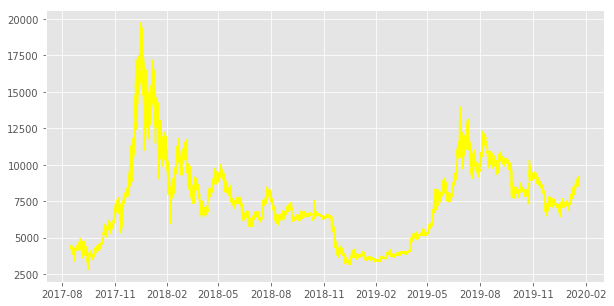

In [35]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df.open, color='yellow')

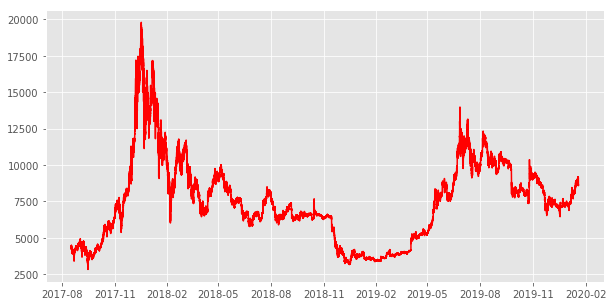

In [37]:
plt.figure(figsize=(10,5))

plt.plot(df.high, color='red')

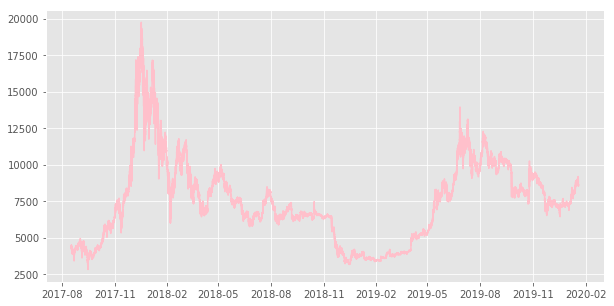

In [38]:
plt.figure(figsize=(10,5))

plt.plot(df.low, color='pink')

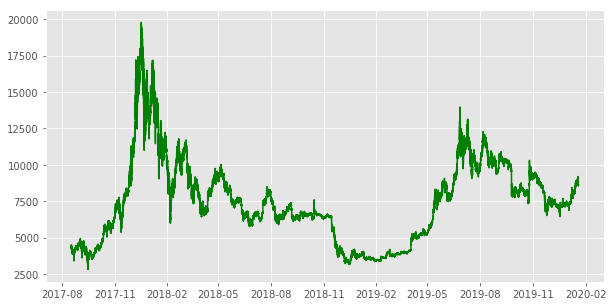

In [39]:
plt.figure(figsize=(10,5))

plt.plot(df.close, color='green')

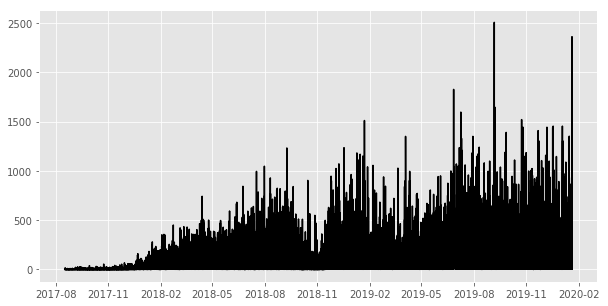

In [40]:
plt.figure(figsize=(10,5))

plt.plot(df.volume, color='black')

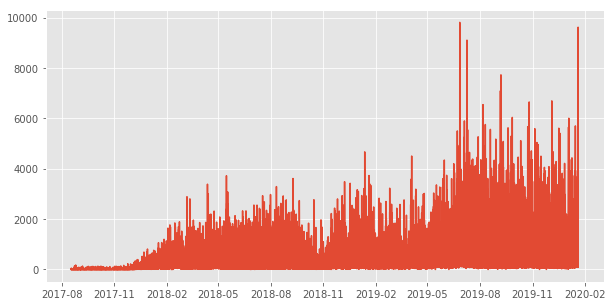

In [41]:
plt.figure(figsize=(10,5))

plt.plot(df.trades)

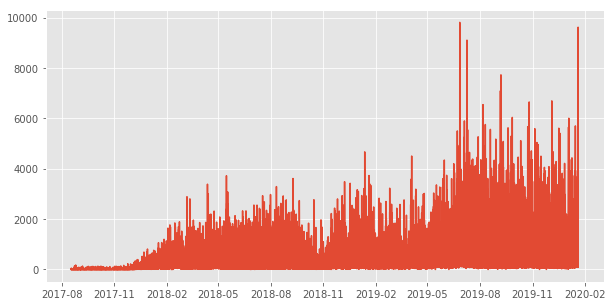

In [27]:
plt.show()

In [ ]:

'''Function to return PreProcessor instance. Needed to for many preprocessing operations
   if no path is supplied then will use the default filepath:BTC-USD:2015-01-01:2017-10-08:daily.csv
   minfactor and maxfactor arguments are used to estimate future max price of data refer to powerpoint
   slides for more information.
   Args: path (.csv) 
         minfactor [0,1]
         maxfactor [1,infinity)
   Return: Preprocessor instance'''

def loaddata(path = None, minfactor = 1, maxfactor = 7):
    if path is None:
        path = os.path.abspath("BTC-USD:2015-01-01:2017-10-08:daily.csv")
    df = pd.read_csv(path,index_col='time',parse_dates=['time'])
    return PreProcessor(df,minfactor,maxfactor)

In [29]:
#path = 'ETH-USD-2016-01-01-2017-11-08-daily.csv'
minfactor=1
maxfactor=7
findata = PreProcessor(df,minfactor, maxfactor)

In [30]:
findata

In [31]:
findata.generate(drop = True)
findata.dropNA()
processedData = findata.getData(original=False,isReference=True)
processedData.replace([np.inf, -np.inf], np.nan).dropna(how="all",inplace=True)

/apps/cent7/anaconda/5.1.0-py36-new/lib/python3.6/site-packages/pywt/_multilevel.py:148: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = a[[slice(s) for s in d.shape]]


In [32]:
processedData

,open,high,low,close,vwp,volume,trades,MAVG5,MAVG10,EMAVG20,bollmid,bollLower,bollUpper,MACD,roc,true range,stochMI,CCI,mtm180,mtm360
date,,,,,,,,,,,,,,,,,,,,
2017-08-17 10:00:00,4434.176736,4434.176736,4434.176736,4434.176736,4434.176736,0.661359,1,4436.172272,4436.768656,4433.436104,4437.732063,4433.784356,4441.679769,6.716700,-0.001343,0.425989,0.770640,-14.353086,113.075610,166.968966
2017-08-17 10:01:00,4434.176736,4434.176736,4434.176736,4434.176736,4434.176736,0.661359,0,4435.673388,4436.172272,4433.506640,4437.306074,4433.194247,4441.417900,6.041922,-0.001343,0.425989,0.719802,-12.279786,113.075610,166.968966
2017-08-17 10:02:00,4434.176736,4434.176736,4434.176736,4434.176736,4434.176736,0.661359,0,4435.174504,4435.922830,4433.570459,4436.880085,4432.797630,4440.962541,5.444395,-0.001343,0.425989,0.666288,-10.762118,113.075610,164.927900
2017-08-17 10:03:00,4434.176736,4434.176736,4434.176736,4434.176736,4434.176736,0.661359,1,4434.675620,4435.673388,4433.628199,4436.454096,4432.598922,4440.309271,4.914204,-0.001343,0.425989,0.611400,-9.577339,113.075610,169.010032
2017-08-17 10:04:00,4432.930623,4432.930623,4432.930623,4432.930623,4432.930623,0.661359,1,4433.927514,4435.299335,4433.561764,4435.939100,4432.284206,4439.593993,4.343404,-0.001624,0.514997,0.569197,-11.441527,111.713963,165.722853
2017-08-17 10:05:00,4432.930623,4432.930623,4432.930623,4432.930623,4432.930623,0.661359,0,4433.678291,4434.925282,4433.501655,4435.424103,4432.330700,4438.517506,3.846699,-0.001624,0.514997,0.530505,-10.177738,111.713963,165.722853
2017-08-17 10:06:00,4426.656783,4426.656783,4407.025717,4407.025717,4412.878168,0.661359,3,4428.248087,4431.960738,4430.980137,4433.306572,4417.881938,4448.731205,1.347217,-0.007458,2.117531,0.340888,-25.610402,85.809057,139.817947
2017-08-17 10:07:00,4414.524651,4414.524651,4407.025717,4407.025717,4412.878168,0.661359,1,4422.817883,4428.996194,4428.698764,4431.189040,4410.509615,4451.868465,-0.626419,-0.007458,2.653169,0.145565,-20.289331,85.809057,139.817947
2017-08-17 10:08:00,4401.699420,4401.723170,4401.699420,4401.723170,4401.722963,0.661359,1,4416.327170,4425.501395,4426.129660,4428.692755,4403.027638,4454.357873,-2.588572,-0.008652,3.033619,-0.037114,-18.990148,80.737577,134.515400


In [ ]:
trainpercent = .8
train , test = findata.split(trainpercent)
trainScaled = findata.normalize(train.copy(),featureRange=(-1,1),type='minmax')
testScaled = findata.normalize(test.copy(),featureRange=(-1,1),type='minmax')

'''Specify lookback window (period)'''
lookback = 2
'''Specify which columns to actually use'''
columns = train.columns
'''Create moving window to train LSTM'''
train_X , train_Y = findata.createWindow(trainScaled[columns],look_backX=lookback)
test_X, test_Y = findata.createWindow(testScaled[columns],look_backX=lookback)



neurons = [100,1]
epochs = 600; batch = 128
lossfunc = 'mae'; optimizer = 'adam'

'''Function build model, modify by adding layers to function and specify neurons
   Takes additional argument previousModel
   
   Argument shape is very import, training set must have shape of dimensions (samples,lookback,numfeatures)
   Example if we have timeseries of 1-d (numfeatures = 1) like [1,2,3,4,5], with lookback of 2 and then
   our moving window dataset would look like: for train_X [[1,2],[2,3],[3,4]]
                                                  train_Y       [[3],[4],[5]]
                                                       
   If you wish to build a neural net and add LSTM layer supply instance
   of type Model of pretrained net.'''

def buildModel(shape,neuron,previousModel=None):
    if previousModel is None:
        previous = Input(shape=(shape[1], shape[2]))
    else:
        previous = previousModel.output

    lstmlayer = LSTM(neuron[0],return_sequences=False,recurrent_dropout=.3)(previous)
    outlayer = Dense(neuron[-1],activation='linear')(lstmlayer)

    return Model(previous,outlayer,name='cryptobot')

crypto = buildModel(np.shape(train_X),neurons)
crypto.compile(loss =lossfunc,optimizer=optimizer)
history = crypto.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=epochs, batch_size=batch)

'''Prints plots of:
    -curve fit on training set
    -curve fit on testing set
    -training/testing error'''

def printplots(crypto,findata,training,testing,lookback,title):
    plt.close('all')
    train = training[0]
    test = testing[0]
    train_X = training[1]
    train_Y = training[2]
    test_X = testing[1]
    test_Y = testing[2]

    predict = crypto.predict(train_X)
    predictDF = pd.DataFrame(predict,columns=['close'])
    actualDF = pd.DataFrame(train_Y,columns=['close'])
    trainpredictOriginal = findata.normalizeInverse(predictDF,initial=None,type='minmax')
    trainactualOriginal = findata.normalizeInverse(actualDF,initial=None,type='minmax')
    trainpredictOriginal.index = train.index[lookback:]
    trainactualOriginal.index = train.index[lookback:]

    fig = plt.figure()
    plt.title(title[0])
    plt.plot(trainpredictOriginal,label= 'predicted')
    plt.plot(trainactualOriginal,label = 'actual')
    plt.legend()
    fig.autofmt_xdate()

    predict = crypto.predict(test_X)

    predictDF = pd.DataFrame(predict,columns=['close'])
    actualDF = pd.DataFrame(test_Y,columns=['close'])

    testpredictOriginal = findata.normalizeInverse(predictDF,initial=None,type='minmax')
    testactualOriginal = findata.normalizeInverse(actualDF,initial=None,type='minmax')
    testpredictOriginal.index = test.index[lookback:]
    testactualOriginal.index = test.index[lookback:]
    print(mean_absolute_error(testactualOriginal.values,testpredictOriginal.values))
    fig = plt.figure()
    plt.title(title[1])

    plt.plot(testpredictOriginal, label = 'predicted')
    plt.plot(testactualOriginal, label = 'actual')
    plt.legend(loc='upper left')
    fig.autofmt_xdate()

    plt.figure()
    plt.title('Training and Validation Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.show(block = False)

product = 'BTC'
titles = [product + ' Predicted Prices (Training)',product + ' Predicted Prices (Validation)']
printplots(crypto, findata, [train, train_X, train_Y], [test, test_X, test_Y], lookback,titles)

'''Returns actual and predicted converted back to real daily closing prices
   before they were scaled to range (-1,1)'''
def getactualPrices(crypto,findata,training,testing,lookback):
    train = training[0]
    test = testing[0]
    train_X = training[1]
    train_Y = training[2]
    test_X = testing[1]
    test_Y = testing[2]
    predict = crypto.predict(test_X)

    predictDF = pd.DataFrame(predict, columns=['close'])
    actualDF = pd.DataFrame(test_Y, columns=['close'])

    testpredictOriginal = findata.normalizeInverse(predictDF, initial=None, type='minmax')
    testactualOriginal = findata.normalizeInverse(actualDF, initial=None, type='minmax')
    testpredictOriginal.index = test.index[lookback:]

    testactualOriginal.index = test.index[lookback:]
    return [testpredictOriginal,testactualOriginal]


'''Evaluates metrics on accuracy of forcasting model
   Refer to slides for more details'''
transactionfee = .0025
def performanceMetrics(actual,predicted,test,transactionfee=.0001):
    actualprices = test[lookback - 1:]
    B = transactionfee
    S = B

    returns = 0
    for index in range(len(actualprices) - 1):
        predictedPrice = predicted.iloc[index].close
        actualPrice = actualprices.iloc[index].close
        actualPrice_nextday = actualprices.iloc[index + 1].close
        if predictedPrice > actualPrice:
            returns += (actualPrice_nextday - actualPrice - (B * actualPrice + S * actualPrice_nextday)) / actualPrice

        elif predictedPrice < actualPrice:
            returns += (actualPrice - actualPrice_nextday - (B * actualPrice_nextday + S * actualPrice)) / actualPrice
    actual = actual.values.reshape((1,-1))[0]
    predicted = predicted.values.reshape((1,-1))[0]
    pearson_corr , p_value = pearsonr(actual,predicted)
    theil_U= np.sqrt(mean_squared_error(actual,predicted)) / (np.sqrt(np.sum(np.square(predicted)))  + np.sqrt(np.sum(np.square(actual))) )
    mape = np.mean(np.abs((actual- predicted) / actual))

    metrics = ['R', 'Theil U', 'MAPE','Percent Return']
    return pd.Series([pearson_corr,theil_U,mape,returns],index=metrics)

predicted, actual = getactualPrices(crypto,findata,[train,train_X,train_Y],[test,test_X,test_Y],lookback)
performanceMetrics(actual,predicted,test,transactionfee)